In [1]:
# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['text.usetex'] = True

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from fittools import *
from formattools import *
# style = styles['prd_twocol']
style = styles['notebook']

import gvar as gv
import lsqfit
import corrfitter as cf

from __future__ import print_function

try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

## Process data and show current fits

In [2]:
# Set the ensemble index.
ens_idx = 0
ensemble = ['24I/ml_0p01', '24I/ml_0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004'][ens_idx]
ens_path = ['24I/ml0p01', '24I/ml0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004'][ens_idx]
f_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + ensemble + '/fit_params.h5'
n_ops = 5

# read in input to plot
f = h5py.File(f_path, 'r')
data_slice = f['data_slice'][()]
c = f['c'][()]
sigmac = f['sigmac'][()]
plot_domain = f['plot_domain'][()]
f.close()

data_plot_mu = np.mean(data_slice, axis = 0)
data_plot_sigma = np.std(data_slice, axis = 0, ddof = 1)

In [3]:
# set specific ranges and labels
ytick_labels = [
    [['-5.8', '-5.4', '-5.0'], ['-1.0', '-0.9', '-0.8'], ['3.4', '3.6', '3.8'], ['-1.9', '-1.7', '-1.5'], ['2.1', '2.3', '2.5']],         # 24I/ml0p01
    [['-5.0', '-4.7', '-4.4'], ['-8.5', '-8.0', '-7.5'], ['1.70', '1.85', '2.00'], ['-1.55', '-1.45', '-1.35'], ['1.80', '1.95', '2.10']],      # 24I/ml0p005
    [['-1.90', '-1.75', '-1.60'], ['-2.9', '-2.7', '-2.5'], ['8.00', '8.75', '9.50'], ['-5.8', '-5.3', '-4.8'], ['6.2', '6.7', '7.2']],      # 32I/ml0p008
    [['-1.70', '-1.55', '-1.40'], ['-2.7', '-2.5', '-2.3'], ['5.7', '6.2', '6.7'], ['-5.5', '-5.0', '-4.5'], ['5.8', '6.2', '6.6']],      # 32I/ml0p006
    [['-1.55', '-1.45', '-1.35'], ['-2.40', '-2.25', '-2.10'], ['3.4', '3.8', '4.2'], ['-4.9', '-4.5', '-4.1'], ['5.2', '5.6', '6.0']],      # 32I/ml0p004
][ens_idx]
pwr = [
    [-3, -2, -4, -2, -3],
    [-3, -3, -4, -2, -3],
    [-3, -3, -5, -3, -4],
    [-3, -3, -5, -3, -4],
    [-3, -3, -5, -3, -4]
][ens_idx]              # think about doing using \\text{-}
yrangep = [
    [[-0.0060, -0.0048], [-0.0105, -0.0075], [0.00033, 0.00039], [-0.02, -0.014], [0.0020, 0.0026]],
    [[-0.0051, -0.0043], [-0.00875, -0.00725], [0.000165, 0.000205], [-0.016, -0.013], [0.00175, 0.00215]],
    [[-0.002, -0.0015], [-0.0030, -0.0024], [0.0000775, 0.0000975], [-0.0061, -0.0045], [0.00059, 0.00075]],
    [[-0.00175, -0.00135], [-0.0028, -0.0022], [0.000054, 0.00007], [-0.00575, -0.00425], [0.00056, 0.00068]],
    [[-0.0016, -0.0013], [-0.00245, -0.00205], [0.000032, 0.000044], [-0.005, -0.004], [0.0005, 0.00062]]
][ens_idx]
ytick_locs = [[round(float(ytick_labels[k][i]) * (10 ** pwr[k]), np.abs(pwr[k]) + 2) for i in range(len(ytick_labels[k]))] for k in range(n_ops)]
# yaxis_labels = ['$' + latex_labels[ii] + '^{\\mathrm{eff}} \\hspace\{-1.0mm\} \\times \\hspace{-0.5mm} 10^{' + str(pwr[ii]) + '}$' for ii in range(len(latex_labels))]

latex_labels = [r'O_1', r'O_2', r'O_3', r'O_{1^\prime}', r'O_{2^\prime}']
yaxis_labels = [r'$' + latex_labels[ii] + r'^{\mathrm{eff}} \hspace{-1.0mm} \times \hspace{-0.5mm} 10^{' + str(pwr[ii]) + r'}$' for ii in range(len(latex_labels))]

In [4]:
asp_ratio = 4/3
fig_size = (style['colwidth'], style['colwidth'] / asp_ratio)
def plot_data(cvs, stds, yaxis_label, ylims = None, yt_locs = None, yt_labels = None, mrk = '.', col = 'r'):
    dom = plot_domain[:len(cvs)]
    with sns.plotting_context('paper'):
        plt.figure(figsize = fig_size)
        _, caps, _ = plt.errorbar(dom, cvs, yerr = stds, fmt = mrk, c = col, \
                     capsize = style['endcaps'], markersize = style['markersize'], elinewidth = style['ebar_width'])
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
        plt.xlabel('$t / a$', fontsize = style['fontsize'])
        plt.ylabel(yaxis_label, fontsize = style['fontsize'])
        ax = plt.gca()
        ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        if yt_locs:
            ax.set_yticks(yt_locs)
            ax.set_yticklabels(yt_labels)
        for spine in spinedirs:
            ax.spines[spine].set_linewidth(style['axeswidth'])
        plt.xticks(fontsize = style['fontsize'])
        plt.yticks(fontsize = style['fontsize'])
        #plt.xlim(0, max(list(plot_domain)) // 2 + 1.5)
        if ylims:
            plt.ylim(ylims[0], ylims[1])
        plt.tight_layout()
        plt.show()
def plot_data_fn(cvs, stds, fn, yaxis_label, ylims = None, yt_locs = None, yt_labels = None, mrk = '.', col = 'r'):
    """Plots data and a function on the same figure to get an idea of what the fit parameters should tune to."""
    dom = plot_domain[:len(cvs)]
    with sns.plotting_context('paper'):
        plt.figure(figsize = fig_size)
        _, caps, _ = plt.errorbar(dom, cvs, yerr = stds, fmt = mrk, c = col, \
                     capsize = style['endcaps'], markersize = style['markersize'], elinewidth = style['ebar_width'])
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
        plt.plot(dom, [fn(t) for t in dom], c = 'b')
        plt.xlabel('$t / a$', fontsize = style['fontsize'])
        plt.ylabel(yaxis_label, fontsize = style['fontsize'])
        ax = plt.gca()
        ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        if yt_locs:
            ax.set_yticks(yt_locs)
            ax.set_yticklabels(yt_labels)
        for spine in spinedirs:
            ax.spines[spine].set_linewidth(style['axeswidth'])
        plt.xticks(fontsize = style['fontsize'])
        plt.yticks(fontsize = style['fontsize'])
        #plt.xlim(0, max(list(plot_domain)) // 2 + 1.5)
        if ylims:
            plt.ylim(ylims[0], ylims[1])
        plt.tight_layout()
        plt.show()
def plot_fit(cvs, stds, fit_x, fit_lower, fit_upper, yaxis_label, ylims = None, yt_locs = None, yt_labels = None, \
             mrk = '.', col = 'r'):
    dom = plot_domain[:len(cvs)]    # in case plot_domain needs truncation
    with sns.plotting_context('paper'):
        plt.figure(figsize = fig_size)
        _, caps, _ = plt.errorbar(dom, cvs, yerr = stds, fmt = mrk, c = col, \
                     capsize = style['endcaps'], markersize = style['markersize'], elinewidth = style['ebar_width'])
        #plt.fill_between(fit_x, fit_lower, fit_upper, color = col, alpha = 0.3, linewidth = 0.0)
        plt.fill_between(fit_x, fit_lower, fit_upper, color = col, alpha = 0.5, linewidth = 0.0)
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
        plt.xlabel('$t / a$', fontsize = style['fontsize'])
        plt.ylabel(yaxis_label, fontsize = style['fontsize'])
        ax = plt.gca()
        ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        if yt_locs:
            ax.set_yticks(yt_locs)
            ax.set_yticklabels(yt_labels)
        for spine in spinedirs:
            ax.spines[spine].set_linewidth(style['axeswidth'])
        plt.xticks(fontsize = style['fontsize'])
        plt.yticks(fontsize = style['fontsize'])
        plt.xlim(0, max(list(plot_domain)) // 2 + 1.5)
        if ylims:
            plt.ylim(ylims[0], ylims[1])
        plt.tight_layout()
        plt.show()
def const_fit_band(cv, std, xlims = (0, max(list(plot_domain)) // 2 + 1.5)):
    xx = np.linspace(xlims[0], xlims[1], 500)
    lower_band = np.full(xx.shape, cv - std)
    upper_band = np.full(xx.shape, cv + std)
    return xx, lower_band, upper_band
def get_fit_band(params, fcn, xlims):
    xx = np.linspace(xlims[0], xlims[1], 500)
    fx = fcn(xx, params)
    fx_lower = gv.mean(fx) - gv.sdev(fx)
    fx_upper = gv.mean(fx) + gv.sdev(fx)
    return xx, fx_lower, fx_upper

In [5]:
# Use this code block if I make this notebook into production code
f3pt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' +ensemble+ '/SD_output.h5'

f = h5py.File(f3pt_path, 'r')
L, T = f['L'][()], f['T'][()]
vol = (L**3)# * T
C2pt_tavg = f['pion-00WW'][()]
# C2WW = f['C2pt'][()]
C2_pion00WP = np.real(f['pion-00WP'][()]) / vol
C3pt_tavg = f['C3pt'][()]
Cnpt = f['Cnpt'][()]
R_boot = f['R'][()]
mpi_boot = f['mpi'][()]
f.close()

# fold 2-point WW. Note that we need this for the R-ratio, but the WP gives a cleaner 2-point signal for mpi fits
C2_fold = np.real(fold(C2pt_tavg, T))
# C2_mu = np.mean(C2_fold, axis = 0)
# C2_sigma = np.std(C2_fold, axis = 0, ddof = 1)

# get WP pion mass
meff = get_cosh_effective_mass(C2_pion00WP)
C2_folded = np.real(fold(C2_pion00WP, T))
C2_mu = np.mean(C2_folded, axis = 0)
C2_sigma = np.std(C2_folded, axis = 0, ddof = 1)
meff_folded = fold_meff(meff, T)
meff_mu = np.mean(meff_folded, axis = 0)
meff_sigma = np.std(meff_folded, axis = 0, ddof = 1)

# process data points and make ready to fit
R_mu = np.mean(R_boot, axis = 0)
R_sigma = np.std(R_boot, axis = 0, ddof = 1)
data_slice = np.zeros((n_boot, n_ops, T), dtype = np.float64)
plot_domain = range(T)
for i in range(n_ops):
    for sep in range(T):
        if sep % 2 == 0:
            data_slice[:, i, sep] = np.real(R_boot[:, i, sep // 2, sep])
        else:
            data_slice[:, i, sep] = np.real((R_boot[:, i, sep // 2, sep] + R_boot[:, i, sep // 2 + 1, sep]) / 2)
data_plot_mu = np.mean(data_slice, axis = 0)
data_plot_sigma = np.std(data_slice, axis = 0, ddof = 1)

/Users/theoares/lqcd/0nubb/python_scripts/utils.py:220: ComplexWarning: Casting complex values to real discards the imaginary part
  folded[:, 0] = C[:, 0]
/Users/theoares/lqcd/0nubb/python_scripts/utils.py:223: ComplexWarning: Casting complex values to real discards the imaginary part
  folded[:, t + 1] = (C[:, t + 1] + C[:, T - (t + 1)]) / 2


## Fit mpi

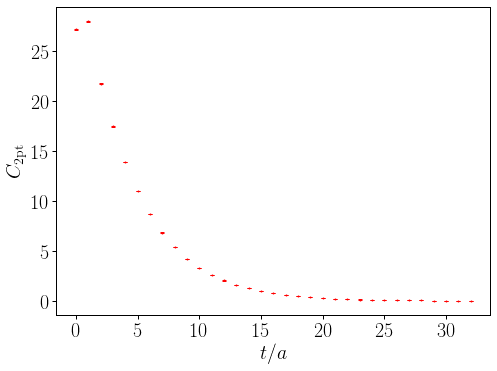

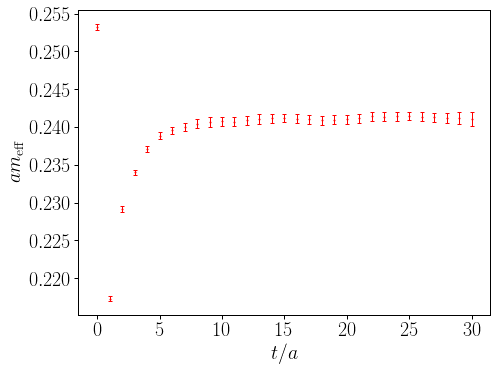

In [7]:
# plot 2-points
plot_data(C2_mu, C2_sigma, '$C_{2\mathrm{pt}}$')  # '$C_{2\mathrm{pt}}$'
plot_data(meff_mu, meff_sigma, '$am_{\mathrm{eff}}$')

#### Constant fits of effective mass to a given range (my code)

In [9]:
def const(params):
    def model(t):
        return params[0]
    return model
constant_model = Model(const, 1, [''], ['c0'])

In [10]:
mpi_domain = np.arange(12, 29)
fitter = BootstrapFitter(mpi_domain, meff_folded[:, mpi_domain], constant_model)
# fitter = UncorrFitter(mpi_domain, meff_mu[mpi_domain], meff_sigma[mpi_domain], constant_model)
mpi_params_c, chi2_c, ndof_c, mpi_covar_c = fitter.fit()
mpi_mu_c = mpi_params_c[0]
mpi_std_c = np.sqrt(mpi_covar_c[0, 0])
print('Mpi = ' + export_float_latex(mpi_mu_c, mpi_std_c) + ' with chi^2 / ndof = ' + str(chi2_c / ndof_c))

Fitting data: [0.24088537 0.24106981 0.2411842  0.24119753 0.24111457 0.24104779
 0.24091662 0.24098463 0.2410112  0.24117734 0.24141461 0.24138038
 0.24141176 0.24146834 0.24136726 0.24130491 0.24122686] at x positions: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
Mpi = 0.24125(38) with chi^2 / ndof = 1.4453391072387105


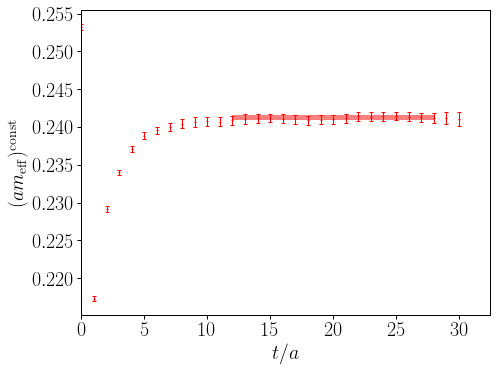

In [11]:
fit_x, fit_lower, fit_upper = const_fit_band(mpi_mu_c, mpi_std_c, xlims = (mpi_domain[0], mpi_domain[-1]))
plot_fit(meff_mu, meff_sigma, fit_x, fit_lower, fit_upper, '$(am_{\mathrm{eff}})^{\mathrm{const}}$')

#### Constant fits of effective mass with lsqfit and corrfitter

Need to figure out how to interface my current workflow with lsqfit and corrfitter. It looks like I'll need to specify the following things: a make_data() function (or just do it myself with my given data), a make_models() function, N (number of terms in the fit form), a make_prior() function, and a print_results() function.
- data: This is a dictionary mapping {times -> bootstrap_array}, i.e. we should send each time we want to fit to the 50-dim np.array

In [70]:
# assemble data into correct form
def make_data(corr, domain):
    """
    Makes data for lsqfit. corr is an np.array of shape (n_boot, T).
    """
    d = {t : corr[:, t] for t in domain}
    df = pd.DataFrame(d)
    mean = np.array(df.mean())
    cov = np.array(df.cov())
    return domain, gv.gvar(mean, cov)

In [12]:
def make_prior():
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    prior['m'] = gv.gvar(0.0, 1.0)
    return prior

def fcn(t, p):
    """Constant fitting function f(t) = m."""
    m = p['m']
    return m + 0*t

# def fitargs(z):
#     prior = gv.BufferDict() 
#     prior['m'] = gv.gvar(gv.gvar(fit.p['a'].mean, z[0]))
#     return dict(prior=prior, fcn=fcn, data=(x,y))

In [13]:
#mpi_domain = np.arange(12, 29)
mpi_domain = np.arange(16, 29)
t_dom, meff = make_data(meff_folded, mpi_domain)
prior = make_prior()
p0 = None
fit = lsqfit.nonlinear_fit(data = (t_dom, meff), fcn = fcn, prior = prior, p0 = p0)
print(fit)
mean_c, std_c = fit.p['m'].mean, fit.p['m'].sdev

Least Square Fit:
  chi2/dof [dof] = 1.2 [13]    Q = 0.29    logGBF = 91.424

Parameters:
              m   0.24161 (44)      [  0.0 (1.0) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 4/0.0)
  fitter = scipy_least_squares    method = trf



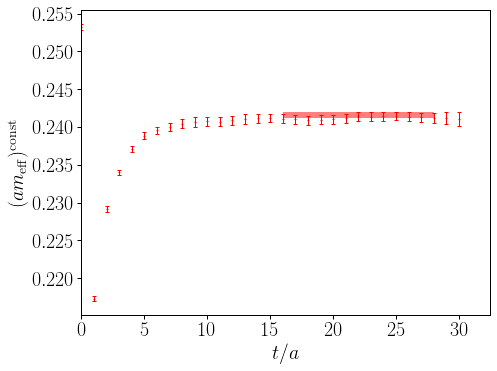

In [14]:
fit_x, fit_lower, fit_upper = get_fit_band(fit.p, fcn, xlims = (mpi_domain[0], mpi_domain[-1]))
plot_fit(meff_mu, meff_sigma, fit_x, fit_lower, fit_upper, '$(am_{\mathrm{eff}})^{\mathrm{const}}$')

#### Ground state fits of $m_\pi$ to correlator data with lsqfit

In [15]:
def make_data(corr, domain):
    """
    Makes data for lsqfit. corr is an np.array of shape (n_boot, T).
    """
    d = {t : corr[:, t] for t in domain}
    df = pd.DataFrame(d)
    mean = np.array(df.mean())
    cov = np.array(df.cov())
    return mpi_domain, gv.gvar(mean, cov)

def make_prior():
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    #prior['Z'] = gv.gvar('0.1(5)')
    prior['Z'] = gv.gvar(40, 40)
    prior['m'] = gv.gvar(0.25, 0.05)
    #prior['m'] = gv.gvar('0.24161(44)')
    return prior

def fcn(t, p):
    """Single exponential fitting function f(t) = Z e^{-mt}."""
    Z = p['Z']
    m = p['m']
    return Z * np.exp(-m * t)

# def fitargs(z):
#     prior = gv.BufferDict() 
#     prior['m'] = gv.gvar(gv.gvar(fit.p['a'].mean, z[0]))
#     return dict(prior=prior, fcn=fcn, data=(x,y))

In [16]:
mpi_domain = np.arange(10, 20)    # domain to modify
# mpi_domain = np.arange(10, 16)    # domain to modify
t_dom, C2 = make_data(C2_folded, mpi_domain)
prior = make_prior()
p0 = None
fit = lsqfit.nonlinear_fit(data = (t_dom, C2), fcn = fcn, prior = prior, p0 = p0)
print(fit)
mean_c, std_c = fit.p['m'].mean, fit.p['m'].sdev
Z_mu, Z_std = fit.p['Z'].mean, fit.p['Z'].sdev

Least Square Fit:
  chi2/dof [dof] = 1.4 [10]    Q = 0.17    logGBF = 58.224

Parameters:
              Z     36.94 (16)      [    40 (40) ]  
              m   0.24069 (49)      [ 0.250 (50) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 5/0.0)
  fitter = scipy_least_squares    method = trf



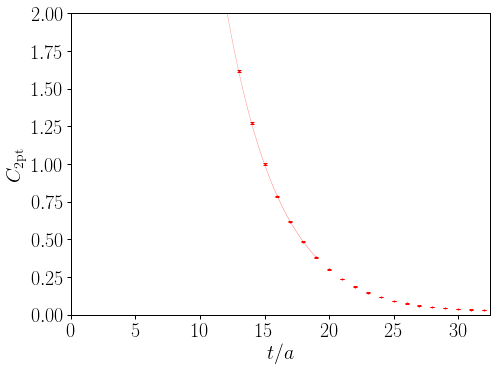

In [17]:
fit_x, fit_lower, fit_upper = get_fit_band(fit.p, fcn, xlims = (mpi_domain[0], mpi_domain[-1]))
plot_fit(C2_mu, C2_sigma, fit_x, fit_lower, fit_upper, '$C_{2\mathrm{pt}}$', ylims = (0, 2))

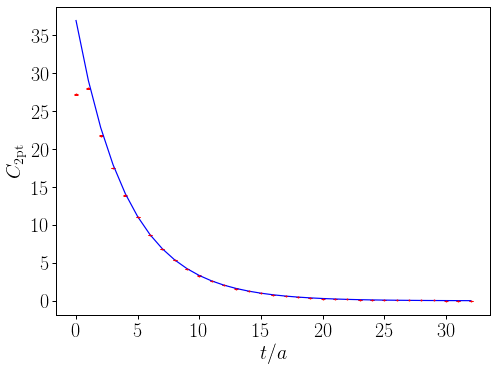

In [18]:
def trial_fn(t):
    #return (5e5) * np.exp(-0.24 * t)
    return Z_mu * np.exp(-mean_c * t)
plot_data_fn(C2_mu, C2_sigma, trial_fn, '$C_{2\mathrm{pt}}$')

#### Try a counter-propagating exponential and to add more data with t > 20

In [19]:
def make_data(corr, domain):
    """
    Makes data for lsqfit. corr is an np.array of shape (n_boot, T).
    """
    d = {t : corr[:, t] for t in domain}
    df = pd.DataFrame(d)
    mean = np.array(df.mean())
    cov = np.array(df.cov())
    return mpi_domain, gv.gvar(mean, cov)

def make_prior():
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    prior['Z0'] = gv.gvar(40, 40)
    prior['Z1'] = gv.gvar(40, 40)
    prior['m'] = gv.gvar(0.25, 0.05)
    #prior['m'] = gv.gvar('0.24161(44)')
    return prior

def fcn(t, p):
    """Exponential fitting function f(t) = Z0 e^{-mt} + Z1 e^{-m(T - t)}."""
    Z0 = p['Z0']
    Z1 = p['Z1']
    m = p['m']
    return Z0 * np.exp(-m * t) + Z1 * np.exp(-m * (T - t))

In [20]:
# mpi_domain = np.arange(10, 25)    # domain to modify
mpi_domain = np.arange(9, 25)    # domain to modify
t_dom, C2 = make_data(C2_folded, mpi_domain)
prior = make_prior()
p0 = None
fit = lsqfit.nonlinear_fit(data = (t_dom, C2), fcn = fcn, prior = prior, p0 = p0)
print(fit)
mean_c, std_c = fit.p['m'].mean, fit.p['m'].sdev
Z0_mu, Z0_std = fit.p['Z0'].mean, fit.p['Z0'].sdev
Z1_mu, Z1_std = fit.p['Z1'].mean, fit.p['Z1'].sdev

Least Square Fit:
  chi2/dof [dof] = 0.94 [16]    Q = 0.52    logGBF = 111.44

Parameters:
             Z0     36.94 (12)      [    40 (40) ]  
             Z1     34.71 (88)      [    40 (40) ]  
              m   0.24081 (39)      [ 0.250 (50) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 5/0.0)
  fitter = scipy_least_squares    method = trf



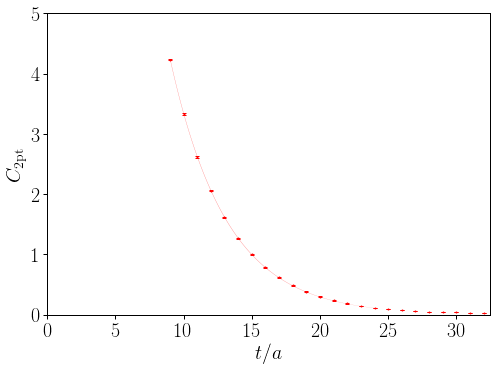

In [21]:
fit_x, fit_lower, fit_upper = get_fit_band(fit.p, fcn, xlims = (mpi_domain[0], mpi_domain[-1]))
plot_fit(C2_mu, C2_sigma, fit_x, fit_lower, fit_upper, '$C_{2\mathrm{pt}}$', ylims = (0, 5))

#### Excited state fits with lsqfit

In [22]:
def make_data(corr, domain):
    """
    Makes data for lsqfit. corr is an np.array of shape (n_boot, T).
    """
    d = {t : corr[:, t] for t in domain}
    df = pd.DataFrame(d)
    mean = np.array(df.mean())
    cov = np.array(df.cov())
    return mpi_domain, gv.gvar(mean, cov)

def make_prior():
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    prior['Z0'] = gv.gvar(40, 40)
    prior['Z1'] = gv.gvar(40, 40)
    #prior['Z2'] = gv.gvar(20, 40)
    prior['Z2'] = gv.gvar(0, 20)
    prior['m'] = gv.gvar(0.25, 0.05)
    prior['dE'] = gv.gvar(0.1, 0.1)
    return prior

def fcn(t, p):
    """Exponential fitting function f(t) = Z0 e^{-mt} + Z1 e^{-m(T - t)}."""
    Z0 = p['Z0']
    Z1 = p['Z1']
    Z2 = p['Z2']
    m = p['m']
    dE = p['dE']
    return Z0 * np.exp(-m * t) + Z1 * np.exp(-m * (T - t)) + Z2 * np.exp(-(m + dE) * t)

In [23]:
# mpi_domain = np.arange(7, 25)    # domain to modify
mpi_domain = np.arange(7, 18)    # domain to modify
t_dom, C2 = make_data(C2_folded, mpi_domain)
prior = make_prior()
p0 = None
fit = lsqfit.nonlinear_fit(data = (t_dom, C2), fcn = fcn, prior = prior, p0 = p0)
print(fit)
mean_c, std_c = fit.p['m'].mean, fit.p['m'].sdev
Z0_mu, Z0_std = fit.p['Z0'].mean, fit.p['Z0'].sdev
Z1_mu, Z1_std = fit.p['Z1'].mean, fit.p['Z1'].sdev

Least Square Fit:
  chi2/dof [dof] = 0.76 [11]    Q = 0.68    logGBF = 57.771

Parameters:
             Z0     37.74 (63)      [    40 (40) ]  
             Z1        42 (32)      [    40 (40) ]  
             Z2     -1.79 (48)      [     0 (20) ]  
              m   0.24154 (83)      [ 0.250 (50) ]  
             dE     0.160 (77)      [  0.10 (10) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 13/0.0)
  fitter = scipy_least_squares    method = trf



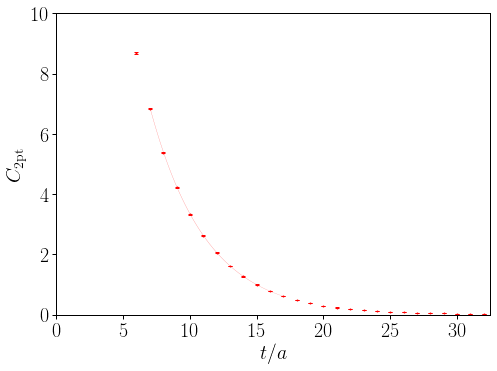

In [24]:
fit_x, fit_lower, fit_upper = get_fit_band(fit.p, fcn, xlims = (mpi_domain[0], mpi_domain[-1]))
plot_fit(C2_mu, C2_sigma, fit_x, fit_lower, fit_upper, '$C_{2\mathrm{pt}}$', ylims = (0, 10))

#### Fit $n_{levels}$ states

In [71]:
def make_prior(N):
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    prior['Z'] = gv.gvar(N * ['40(40)'])
    prior['dE'] = gv.gvar(N * ['0.25(20)'])
    return prior

def fcn(t, p):
    """Exponential fitting function f(t) = \sum_i Z_i e^{- (\sum_{j=1}^i dE_j) t}."""
    Z = p['Z']        # array of Z's
    #print(Z)
    dE = p['dE']
    #print(dE)
    E = np.cumsum(dE)
    #return np.sum( Z * np.exp(-E * t) )
    result = 0.0
    for ii in range(len(E)):
        result += Z[ii] * np.exp(-E[ii] * t)
    return result

In [72]:
mpi_domain = np.arange(6, 18)    # domain to modify
# mpi_domain = np.arange(5, 18)    # domain to modify
t_dom, C2 = make_data(C2_folded, mpi_domain)
p0 = None 

for n_level in range(1, 5):
    print('----- n_level =', n_level, '-----')
    prior = make_prior(n_level)
    fit = lsqfit.nonlinear_fit(data = (t_dom, C2), fcn = fcn, prior = prior, p0 = p0)
    print(fit)                  # print the fit results
    
    Z = fit.p['Z']
    print(Z)
    dE = fit.p['dE']
    E = np.cumsum(dE)
    print(E)

----- n_level = 1 -----
Least Square Fit:
  chi2/dof [dof] = 6.5 [12]    Q = 9.8e-12    logGBF = 32.772

Parameters:
            Z 0     36.07 (11)      [    40 (40) ]  
           dE 0   0.23876 (37)      [  0.25 (20) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 8/0.0)
  fitter = scipy_least_squares    method = trf

[36.07(11)]
[0.23876(37)]
----- n_level = 2 -----
Least Square Fit:
  chi2/dof [dof] = 0.75 [12]    Q = 0.7    logGBF = 61.257

Parameters:
            Z 0     37.17 (20)      [    40 (40) ]  
              1     -2.20 (44)      [    40 (40) ]  *
           dE 0   0.24084 (49)      [  0.25 (20) ]  
              1     0.339 (73)      [  0.25 (20) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 9/0.0)
  fitter = scipy_least_squares    method = trf

[37.17(20) -2.20(44)]
[0.24084(49) 0.579(73)]
----- n_level = 3 -----
Least Square Fit:
  chi2/dof [dof] = 0.83 [12]    Q = 0.62    logGBF = 58.253

Parameter

## Fit 3-point functions

Plotting operator O1


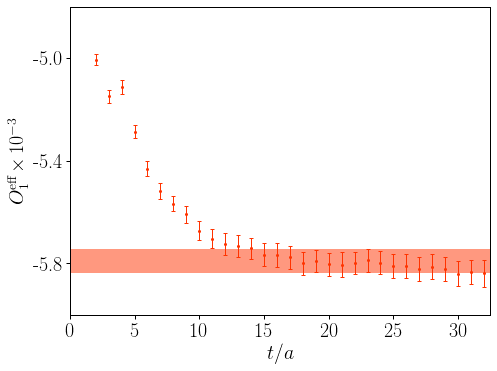

Plotting operator O2


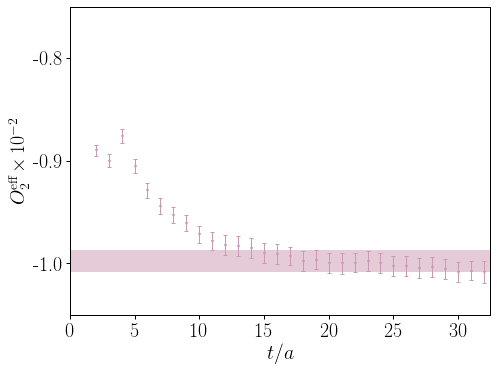

Plotting operator O3


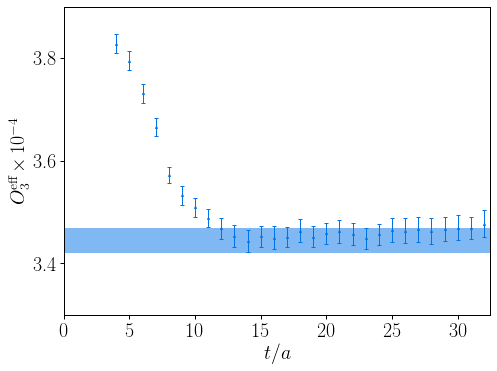

Plotting operator O1p


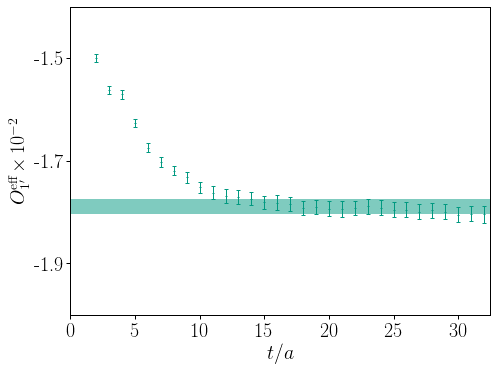

Plotting operator O2p


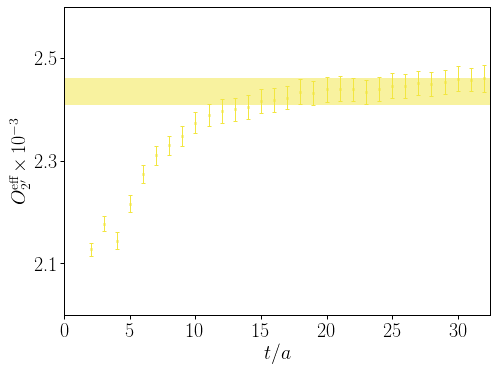

In [8]:
# plot 3-points
for i in range(n_ops):
    print('Plotting operator ' + str(op_labels[i]))
    fit_x, fit_lower, fit_upper = const_fit_band(c[i], sigmac[i])
    plot_fit(data_plot_mu[i], data_plot_sigma[i], fit_x, fit_lower, fit_upper, yaxis_labels[i], yrangep[i], \
             ytick_locs[i], ytick_labels[i], markers[i], colors[i])

#### Constant fits to given range

In [78]:
const_domain = [
    [np.arange(17, 29), np.arange(17, 29), np.arange(17, 29), np.arange(17, 29), np.arange(17, 29)], 
#     [np.arange(12, 29), np.arange(12, 29), np.arange(12, 29), np.arange(12, 29), np.arange(12, 29)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)]
][ens_idx]

In [79]:
def make_prior():
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    prior['c'] = gv.gvar(0.0, 0.1)
    return prior

def fcn(t, p):
    """Constant fitting function f(t; c) = c."""
    c = p['c']
    return c + 0*t

In [80]:
# Fit data_slice[b, k, t]
fit_outs = []
for k in range(n_ops):
    domain = const_domain[k]
    fit_data = data_slice[:, k, :]
    t_dom, Oeff = make_data(fit_data, domain)
    print(t_dom)
    print(Oeff)
    prior = make_prior()
    p0 = None
    fit = lsqfit.nonlinear_fit(data = (t_dom, Oeff), fcn = fcn, prior = prior, p0 = p0)
    print(fit)
    fit_outs.append(fit)

[17 18 19 20 21 22 23 24 25 26 27 28]
[-0.005777(44) -0.005800(46) -0.005791(44) -0.005805(45) -0.005805(48)
 -0.005799(44) -0.005789(46) -0.005797(44) -0.005811(45) -0.005810(48)
 -0.005822(47) -0.005814(49)]
Least Square Fit:
  chi2/dof [dof] = 2.3 [12]    Q = 0.0066    logGBF = 105.06

Parameters:
              c   -0.005731 (34)       [  0.00 (10) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 4/0.0)
  fitter = scipy_least_squares    method = trf

[17 18 19 20 21 22 23 24 25 26 27 28]
[-0.009927(90) -0.009974(97) -0.009965(94) -0.009994(99) -0.01000(10)
 -0.009994(95) -0.009975(97) -0.009998(94) -0.010025(97) -0.010025(96)
 -0.010048(96) -0.010038(98)]
Least Square Fit:
  chi2/dof [dof] = 2.7 [12]    Q = 0.0012    logGBF = 95.888

Parameters:
              c   -0.009822 (72)       [  0.00 (10) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 4/0.0)
  fitter = scipy_least_squares    method = trf

[17 18 19 20 21 22 

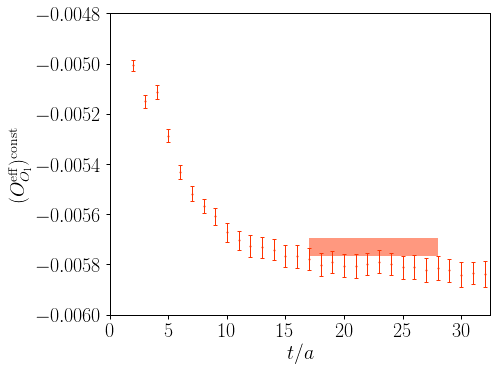

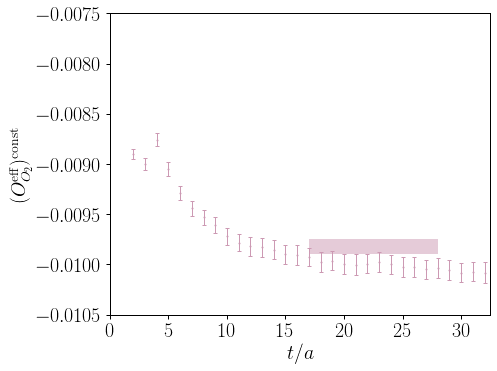

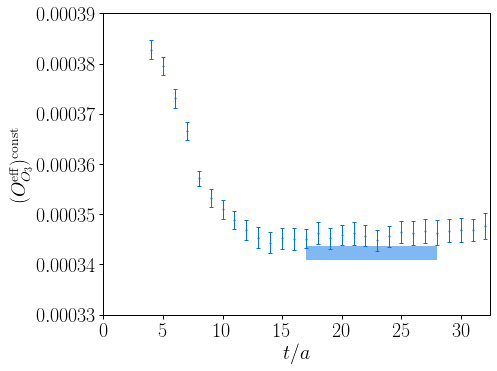

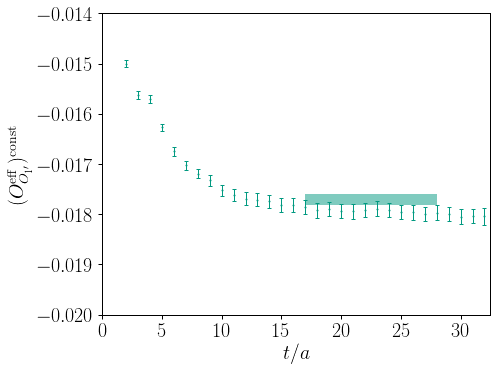

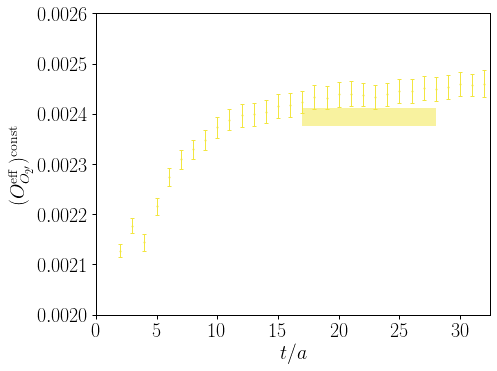

In [81]:
for k in range(n_ops):
    fit_x, fit_lower, fit_upper = get_fit_band(fit_outs[k].p, fcn, xlims = (const_domain[k][0], const_domain[k][-1]))
    plot_fit(data_plot_mu[k], data_plot_sigma[k], fit_x, fit_lower, fit_upper, '$(O_{' + latex_labels[k] \
             + '}^{\mathrm{eff}})^{\mathrm{const}}$', ylims = yrangep[k], col = colors[k])

#### Excited state fit

In [83]:
exc_domain = [
    [np.arange(10, 29), np.arange(10, 29), np.arange(10, 29), np.arange(10, 29), np.arange(10, 29)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)]
][ens_idx]

In [84]:
def make_prior():
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    prior['c0'] = gv.gvar(0.0, 0.1)
    prior['c1'] = gv.gvar(0.0, 0.1)
    prior['dE'] = gv.gvar(0.1, 0.1)
    return prior

def fcn(t, p):
    """Constant fitting function f(t; c) = c."""
    c0 = p['c0']
    c1 = p['c1']
    dE = p['dE']
    return c0 + c1 * np.exp(-dE*t)

In [86]:
# Fit data_slice[b, k, t]. Note the fits don't look great because the data is really correlated, gv.evalcov(Oeff) 
# is the same order of magnitude everywhere
fit_outs = []
for k in range(n_ops):
    domain = exc_domain[k]
    fit_data = data_slice[:, k, :]
    t_dom, Oeff = make_data(fit_data, domain)
    print(t_dom)
    print(Oeff)
    prior = make_prior()
    p0 = None
    fit = lsqfit.nonlinear_fit(data = (t_dom, Oeff), fcn = fcn, prior = prior, p0 = p0)
    print(fit)
    fit_outs.append(fit)

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
[-0.005673(36) -0.005704(37) -0.005726(43) -0.005731(43) -0.005742(42)
 -0.005766(43) -0.005768(46) -0.005777(44) -0.005800(46) -0.005791(44)
 -0.005805(45) -0.005805(48) -0.005799(44) -0.005789(46) -0.005797(44)
 -0.005811(45) -0.005810(48) -0.005822(47) -0.005814(49)]
Least Square Fit:
  chi2/dof [dof] = 2.7 [19]    Q = 7.4e-05    logGBF = 161.43

Parameters:
             c0   -0.005747 (41)       [  0.00 (10) ]  
             c1     0.00051 (17)       [  0.00 (10) ]  
             dE       0.125 (47)       [  0.10 (10) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 14/0.0)
  fitter = scipy_least_squares    method = trf

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
[-0.009719(84) -0.009783(86) -0.009820(96) -0.009831(93) -0.009851(94)
 -0.009898(95) -0.009908(98) -0.009927(90) -0.009974(97) -0.009965(94)
 -0.009994(99) -0.01000(10) -0.009994(95) -0.009975(97) -0.009998(94)
 -0.

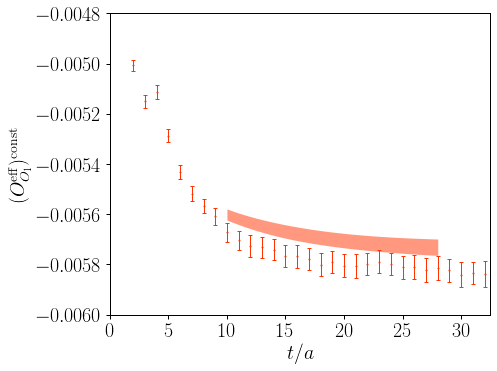

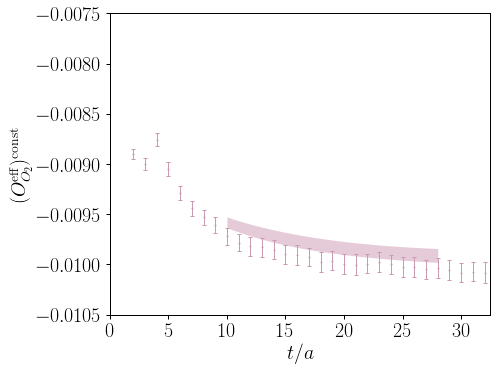

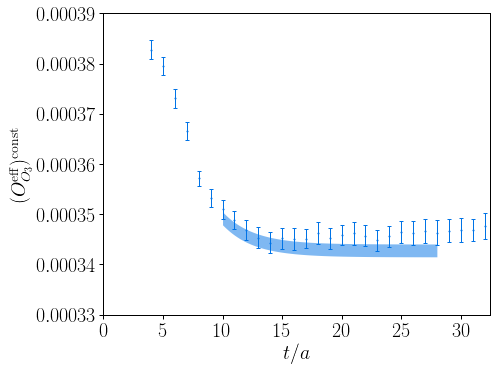

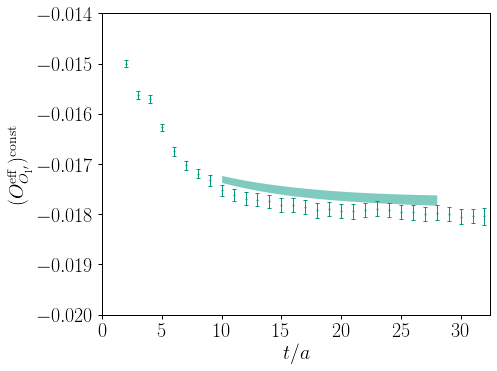

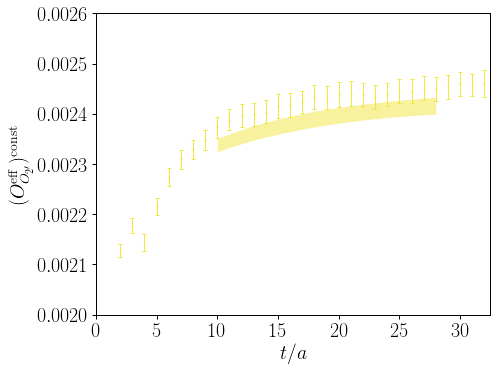

In [87]:
for k in range(n_ops):
    fit_x, fit_lower, fit_upper = get_fit_band(fit_outs[k].p, fcn, xlims = (exc_domain[k][0], exc_domain[k][-1]))
    plot_fit(data_plot_mu[k], data_plot_sigma[k], fit_x, fit_lower, fit_upper, '$(O_{' + latex_labels[k] \
             + '}^{\mathrm{eff}})^{\mathrm{const}}$', ylims = yrangep[k], col = colors[k])

#### Fit $R'$

The typical R-ratio that we construct is:
$$
R(t)\equiv 2 am_\pi \frac{\mathcal C_k(0, t, 2t)}{\mathcal C_{2\mathrm{pt}}(2t) - \frac{1}{2} \mathcal C_{2\mathrm{pt}}(T / 2) e^{m_\pi (2t - T / 2)}}
$$
We subtract off the $C_{2pt}(T / 2)$ in the denominator to subtract off the positive propagating mode, so that the exponentials cancel and the ratio asymptotes to a constant. However, it may be easier in this case to not subtract that off, as we're fitting all the exponentials at once. So, we should also consider:
$$
R'(t)\equiv 2 am_\pi \frac{\mathcal C_k(0, t, 2t)}{\mathcal C_{2\mathrm{pt}}(2t)}
$$

In [37]:
# construct R'
Rp = np.zeros((n_boot, n_ops, T, T), dtype = np.complex64)
for bidx in range(n_boot):
    for i in range(n_ops):
        for t, delta in itertools.product(range(T), repeat = 2):
            R2[bidx, i, t, delta] = 2 * mpi_boot[bidx] * Cnpt[bidx, i, t, delta] / C2pt_tavg[bidx, delta]

### Write out results

In [32]:
# out_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + ensemble + '/fit_params.h5'
# fout = h5py.File(out_file, 'w')
# fout['fits'] = fits
# fout['data_slice'] = data_slice
# fout['c'] = np.array(c)
# fout['sigmac'] = np.array(sigmac)
# fout['plot_domain'] = plot_domain
# fout.close()
# print('Results output to: ' + out_file)